In [1]:
# pip install tika
# pip install -U spacy
# !python -m spacy download zh_core_web_lg
# pip install --upgrade gensim

In [1]:
cd 

/root


In [69]:
ls

2006.zip  2009.zip  2012.zip  2015.zip  2018.zip  2021/
2007.zip  2010.zip  2013.zip  2016.zip  2019.zip  2021.zip
2008.zip  2011.zip  2014.zip  2017.zip  2020.zip  __MACOSX/


In [ ]:
# upzip each year's articles
!unzip 2000.zip

In [1]:
import pandas as pd
import os
import re
import gensim
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt

import tika
tika.initVM()
from tika import parser

# import seaborn as sns
# import spacy 
# nlp = spacy.load("zh_core_web_lg")

In [37]:
from spacy.lang.zh import Chinese

cfg = {"segmenter": "pkuseg"}
nlp = Chinese.from_config({"nlp": {"tokenizer": cfg}})
nlp.tokenizer.initialize(pkuseg_model="mixed")
nlp.tokenizer.pkuseg_update_user_dict(["中日", "两国", "日美", "安倍晋三", "靖国神社",
                                       "钓鱼岛", "钓鱼诸岛", "中日关系", "小泉纯一郎",
                                       "麻生太郎", "胡锦涛", "温家宝", "习近平", 
                                       "李克强", "自民党", "民主党", "朝鲜",
                                       "美国", "东海", "日美关系", "朱镕基", 
                                       "侵华", "抗日", "日本", "中国", "日方",
                                       "中方"])

In [48]:
def get_dataframe(folder):
  """
  Extract data from a folder of articles stored in pdf files, including each
  article's 'title', 'author', 'filepath', 'year'; also read raw texts from 
  pdf files and tokenize the raw texts.
  
  Input:
    folder: the name of folder, e.g. '2020'
  
  Return two items, the first being a pandas dataframe with column 'title', 
  'author', 'filepath', 'year', 'raw_text', 'tokenized_text'; the second being
  a tuple, where the first integer is total number of articles downloaded, the
  second integer is the total number of articles successfully processed
  """
  # extract article meta-data
  paths = []
  authors = []
  names = []
  for filename in os.listdir(folder):
    if filename.endswith(".pdf"):
        try:
          names.append(re.findall(r'[\u4e00-\u9fff]+_', filename)[0][:-1])
        except:
          names.append(filename[:-4])
        paths.append(os.path.abspath(folder) + '/' + filename)
        try:
          authors.append(re.findall(r'_[\u4e00-\u9fff]+\.pdf', filename)[0][1:-4])
        except:
          authors.append('NA')
  years = [folder for i in range(len(names))]
  data = pd.DataFrame({'title': names, 'author': authors, 'filepath': paths, 'year': years })
  prev_total = len(data)

  # read raw texts
  contents = []
  for path in data.filepath:
    parsed = parser.from_file(path)
    contents.append(parsed['content'])
  data['raw_text'] = contents

  # drop rows that have reading errors
  error_row_index = []
  for i, row in data.iterrows():
    if not row['raw_text']:
      error_row_index.append(i)
  data.drop(index=error_row_index, inplace=True)

  # tokenize 
  data['normalized_text'] = data['raw_text'].apply(lambda x: delete_special_symbol(x))
  data['tokenized_text'] = data['normalized_text'].apply(lambda x: tokenize(x))

  # drop rows that have tokenizing errors
  error_row_index2 = []
  for i, row in data.iterrows():
    invalid = 0
    for token in row['tokenized_text'][:100]:
      if re.findall('[^\u4e00-\u9fa5]+', token):
        invalid += 1
    if invalid>= 60 or not row['tokenized_text']:
      error_row_index2.append(i)

  data.drop(index=error_row_index2, inplace=True)
  post_total = len(data)
  stats = prev_total, post_total

  return data, stats

In [5]:
symbol_RE = re.compile(r'[^\w\su4e00-\u9fa5]+')
digit_RE = re.compile(r'\d+')
ENG_RE = re.compile(r'[a-zA-Z]+')

def delete_special_symbol(sentence):
    """
    Delete special symbols, english charcters, and digits in a string using 
    regular expression.
    """
    sentence = [digit_RE.sub('', s) for s in sentence]
    sentence = [ENG_RE.sub('', s) for s in sentence]
    
    return ''.join(n for n in [symbol_RE.sub('', s) for s in sentence])

In [6]:
delete_special_symbol('任�表示233深刻的hfuwe反\n省')

'任表示深刻的反\n省'

In [7]:
def tokenize(word_list, model=nlp):
    """
    Tokenize a string using spacy tokenizing pipeline
    """ 
    tokenized = [] 
    doc = model(word_list, disable=["parser", "ner"])
    for w in doc:
        if (w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num
            and len(w.text.strip()) > 0):
            tokenized.append(w.text)
    
    return tokenized

In [49]:
for year in range(2000, 2022):
  if year == 2000:
    data, stats = get_dataframe(str(year)) 
    prev_total = [stats[0]]
    post_total = [stats[1]] 
  else:
    new_data, stats = get_dataframe(str(year)) 
    data = pd.concat([data, new_data])
    prev_total.append(stats[0])
    post_total.append(stats[1])

In [50]:
data

,title,author,filepath,year,raw_text,normalized_text,tokenized_text
0,国际学术讨论会综述,韦佳,/root/2000/关于影响中日关系发展之因素...日关系”国际学术讨论会综述_韦佳.pdf,2000,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[影响, 中日, 关系, 发展, 因素, 有益, 探索, 新世纪, 中日, 关系, 国际, ..."
1,采访朱总理访日的几点感受,王亚娟,"/root/2000/坦城相待,有所作为——采访朱总理访日的几点感受_王亚娟.pdf",2000,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[国际, 政治, 杀落, 塞, 澎理, 刀, 日, 分日, 日本, 正式, 访问, 刊, 记..."
2,我看中日关系(二),NA,/root/2000/我看中日关系(二).pdf,2000,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[国际, 政治, 娇史, 找, 考, 汉想, 本列, 第一, 期, 谈, 看中, 日关, 系..."
3,新时期中日关系中的几个问题,赵阶琦,/root/2000/新时期中日关系中的几个问题_赵阶琦.pdf,2000,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[新, 时期, 中日, 关系, 中, 赵, 阶琦, 内容, 提要, 中日, 邦交, 正常化,..."
4,对世纪之交中日关系的思考,冯昭奎,/root/2000/怎样做邻居——对世纪之交中日关系的思考_冯昭奎.pdf,2000,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[国际, 政治, 黔, 履样, 位, 户, 鱿, 世纪, 乡, 交中, 日, 关, 系, 思..."
...,...,...,...,...,...,...,...
4,世纪以来日本国家战略的演进及对中日关系的影响,刘江永,/root/2021/21世纪以来日本国家战略的演进及对中日关系的影响_刘江永.pdf,2021,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[世纪, 日本, 国家, 战略, 演进, 中日, 关系, 影响, 刘江永, 内容, 提要, ..."
5,日本对华安全战略,吴怀中,/root/2021/日本对华安全战略_一项制衡议程的新近分析_吴怀中.pdf,2021,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[编者按, 世界, 经历, 百年, 未, 变局, 新冠, 肺炎, 疫情, 肆虐, 全球, 进..."
8,政治学会及其重要会员为中心,孙宏云,/root/2021/中国政治学界对九一八事变后...政治学会及其重要会员为中心_孙宏云.pdf,2021,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[安徽, 师范, 大学, 学报, 人文, 社会, 科学版, 第卷, 第期, 年月, 学科, ..."
10,中国与日本,武萌,/root/2021/西方学者视角下“以史为鉴，...评《中国与日本_直面历史》_武萌.pdf,2021,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[西方, 学者, 视角, 史, 鉴面, 未来, 中日, 关系, 评, 中国, 日本, 直面,..."


In [51]:
data['length'] = data['tokenized_text'].apply(lambda x: len(x))

In [52]:
data.groupby('year')['length'].mean()

year
2000    1715.954545
2001    1951.583333
2002    1869.166667
2003    2288.933333
2004    3272.777778
2005    2229.250000
2006    2121.413043
2007    2429.593750
2008    2238.818182
2009    2475.409091
2010    2963.823529
2011    2409.923077
2012    2906.190476
2013    3486.416667
2014    3344.714286
2015    4408.941176
2016    5026.571429
2017    4484.750000
2018    3558.090909
2019    3216.555556
2020    4496.000000
2021    4343.142857
Name: length, dtype: float64

In [56]:
data.groupby('year')['length'].sum()

year
2000     37751
2001     23419
2002     44860
2003     68668
2004     58910
2005     89170
2006     97585
2007     77747
2008     73881
2009     54459
2010     50385
2011     31329
2012     61030
2013     41837
2014    117065
2015     74952
2016     70372
2017     53817
2018     78278
2019     57898
2020     31472
2021     30402
Name: length, dtype: int64

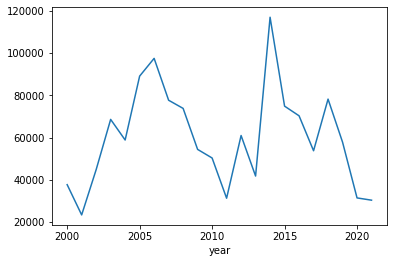

In [54]:
data.groupby('year')['length'].sum().plot();

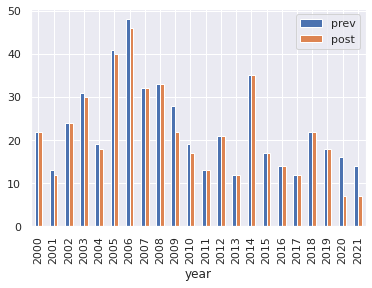

In [73]:
missing_ratio = pd.DataFrame({'prev': prev_total, 'post': post_total, 'year': range(2000,2022)})
missing_ratio.plot(x='year', y=['prev', 'post'], kind='bar');

In [95]:
data.reset_index(drop=True, inplace=True)

In [74]:
data.to_csv('text_data.csv')

In [12]:
data = pd.read_csv('text_data.csv', index_col=[0])

In [14]:
data.head()

,title,author,filepath,year,raw_text,normalized_text,tokenized_text,length,tagged_docs
0,国际学术讨论会综述,韦佳,/root/2000/关于影响中日关系发展之因素...日关系”国际学术讨论会综述_韦佳.pdf,2000,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['影响', '中日', '关系', '发展', '因素', '有益', '探索', '新世...",1124,"TaggedDocument(['影响', '中日', '关系', '发展', '因素', ..."
1,采访朱总理访日的几点感受,王亚娟,"/root/2000/坦城相待,有所作为——采访朱总理访日的几点感受_王亚娟.pdf",2000,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['国际', '政治', '杀落', '塞', '澎理', '刀', '日', '分日', ...",1004,"TaggedDocument(['国际', '政治', '杀落', '塞', '澎理', '..."
2,我看中日关系(二),NaN,/root/2000/我看中日关系(二).pdf,2000,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['国际', '政治', '娇史', '找', '考', '汉想', '本列', '第一',...",1850,"TaggedDocument(['国际', '政治', '娇史', '找', '考', '汉..."
3,新时期中日关系中的几个问题,赵阶琦,/root/2000/新时期中日关系中的几个问题_赵阶琦.pdf,2000,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['新', '时期', '中日', '关系', '中', '赵', '阶琦', '内容', ...",2038,"TaggedDocument(['新', '时期', '中日', '关系', '中', '赵..."
4,对世纪之交中日关系的思考,冯昭奎,/root/2000/怎样做邻居——对世纪之交中日关系的思考_冯昭奎.pdf,2000,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['国际', '政治', '黔', '履样', '位', '户', '鱿', '世纪', '...",1275,"TaggedDocument(['国际', '政治', '黔', '履样', '位', '户..."


In [15]:
keywords = ['中日', '国际', '政治', '贸易', '历史', '地缘', '安全', '合作', '文化', 
            '挑战', '经济', '困境', '机遇', '日本', '中国', '美国', '台湾', '前景', 
            '新', '发展', '冲突', '争议']


In [95]:
taggedDocs = []
for index, row in data.iterrows():
    docKeywords = [s for s in keywords if s in row['tokenized_text']]
    docKeywords.append(str(index))
    taggedDocs.append(gensim.models.doc2vec.TaggedDocument(words=row['tokenized_text'], 
                                                           tags=docKeywords))
data['tagged_docs'] = taggedDocs

In [ ]:
data['tagged_docs'][1]

In [76]:
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [125]:
D2V = gensim.models.doc2vec.Doc2Vec(dm=0, 
                                    vector_size=300,
                                    window=25,
                                    min_count=3,
                                    workers=7,
                                    dm_concat=1,
                                    callbacks=[callback()]) 

In [126]:
D2V.build_vocab(data['tagged_docs'])

In [127]:
D2V.train(data['tagged_docs'], total_examples=D2V.corpus_count, epochs=20)

In [128]:
D2V.save('first_model')

In [131]:
# access matrix representation of the 473th article
D2V.dv.most_similar('473')

[('469', 0.48613911867141724),
 ('470', 0.4689609706401825),
 ('合作', 0.3286418318748474),
 ('186', 0.3233388066291809),
 ('发展', 0.32194289565086365),
 ('地缘', 0.3200075030326843),
 ('472', 0.30889278650283813),
 ('461', 0.3072218596935272),
 ('国际', 0.3057571053504944),
 ('美国', 0.299747496843338)]

In [133]:
data['title'][473]

'中日关系下滑态势将加剧'

In [134]:
data['title'][469]

'世纪以来日本国家战略的演进及对中日关系的影响'

In [135]:
D2V.dv.most_similar(negative='473')

[('263', 0.09038188308477402),
 ('117', 0.08159788697957993),
 ('360', 0.07424749433994293),
 ('119', 0.07355380058288574),
 ('10', 0.0679699033498764),
 ('373', 0.06551533192396164),
 ('168', 0.06343725323677063),
 ('354', 0.06291715055704117),
 ('278', 0.06080149859189987),
 ('362', 0.06075608730316162)]

In [137]:
data['title'][263]

'智勇思想在和谐中日关系中的价值'

In [ ]:
# what words are in vocabulary?
D2V.wv.index_to_key

In [ ]:
D2V['中日']